In [1]:
library(DESeq2)
library(tximport)
library(dplyr)
library(ggplot2)
library(ggrepel)
library(tidyverse)
library(pheatmap)
library(ggthemes)
library(clusterProfiler)
library(enrichplot)
library("org.Hs.eg.db")
library(ggvenn)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb

Loading required package: SummarizedExperiment

Loading required package: M

In [2]:
sessionInfo()

R version 4.2.3 (2023-03-15)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server 7.9 (Maipo)

Matrix products: default
BLAS/LAPACK: /home/trc891/.conda/envs/cfn_final/lib/libopenblasp-r0.3.29.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] ggvenn_0.1.10               org.Hs.eg.db_3.16.0        
 [3] AnnotationDbi_1.60.0        enrichplot_1.18.0          
 [5] clusterProfiler_4.6.0       ggthemes_5.1.0             
 [7] pheatmap_1.0.12             lubridate_1.9.3            
 [9] forcats

In [3]:
options(repr.matrix.max.rows=600, repr.matrix.max.cols=200)

In [4]:
plotPCA_manual = function(object, 
                          intgroup="condition", #essentially ignored if merge_metadata = TRUE
                          ntop=500, 
                          pcs = 2,
                          merge_metadata = FALSE,
                          return_loadings = FALSE,
                          mart_name = "mmusculus",
                          custom_annotation = NULL)
{
#   require(tidyverse)
  
  # calculate the variance for each gene
  rv <- rowVars(assay(object), useNames=TRUE)
  
  # select the ntop genes by variance
  select <- order(rv, decreasing=TRUE)[seq_len(min(ntop, length(rv)))]
  
  # perform a PCA on the data in assay(x) for the selected genes
  pca <- prcomp(t(assay(object)[select,]))
  
  # the contribution to the total variance for each component
  percentVar <- pca$sdev^2 / sum( pca$sdev^2 )
  
  if (!all(intgroup %in% names(colData(object)))) {
    stop("the argument 'intgroup' should specify columns of colData(dds)")
  }
  
  intgroup.df <- as.data.frame(colData(object)[, intgroup, drop=FALSE])
  
  # add the intgroup factors together to create a new grouping factor
  group <- if (length(intgroup) > 1) {
    factor(apply( intgroup.df, 1, paste, collapse=":"))
  } else {
    colData(object)[[intgroup]]
  }
  
  # assemble the data for the plot
  d <- data.frame(group=group, intgroup.df, name=colnames(object))
  tmp = pca$x[, 1:pcs]
  colnames(tmp) = paste0("PC", 1:pcs)
  d = cbind(tmp, d)
  attr(d, "percentVar") <- percentVar[1:pcs]
  
  if(merge_metadata == TRUE)
  {
    md = colData(object) %>% 
      as.data.frame() %>% 
      rownames_to_column("sample")
    d = d %>% 
      dplyr::select(-group) %>% 
      dplyr::rename(sample = name) %>% 
      left_join(., md) %>% 
      column_to_rownames("sample")
  }
      
  
  plt = ggplot(data=d, aes_string(x="PC1", y="PC2", color=group)) + geom_point(size=3) + 
    xlab(paste0("PC1: ",round(percentVar[1] * 100),"% variance")) +
    ylab(paste0("PC2: ",round(percentVar[2] * 100),"% variance")) +
    coord_fixed()
  
  #if requested, return loadings in human-readable format
  if(return_loadings == TRUE)
  {
    if(is.null(custom_annotation))
    {
      require(biomaRt)
      mart = useMart("ensembl", paste0(mart_name, "_gene_ensembl"))
      conv = getBM(attributes = c("ensembl_gene_id", "external_gene_name"),
                   mart = mart)
    } else
    {
      conv = custom_annotation
    }
    
    loadings = pca$rotation %>% 
      as.data.frame() %>% 
      rownames_to_column("ensembl_gene_id") %>% 
      left_join(., conv) %>% 
      dplyr::relocate(ensembl_gene_id, external_gene_name) %>% 
      arrange(desc(PC1))
  } else
  {
    loadings = NULL
  }
  
  #output percent variance for each PC as a tidy data frame
  percent_var = data.frame(component = 1:pcs, percent_var = round(percentVar[1:pcs] * 100))
  
  return(list(pca = pca, data = d, plot = plt, loadings = loadings, percent_var = percent_var))
}

In [5]:
sfig1.data.dir = "/home/trc891/projects/cyb/2022-CFnose/data/02ireland_sala"
sfig1.out.dir = "/home/trc891/projects/cyb/2022-CFnose/data/10paper_figures/sfig1"

In [6]:
# load demographic info
sfig1.demo <- read.csv(file.path(sfig1.data.dir, "ireland_samples_20250305.csv"))
sfig1.demo$Subj <- as.factor(sfig1.demo$Subj)

In [7]:
sfig1.demo

Sample,Subj,Age,Sex,V
<chr>,<fct>,<int>,<chr>,<chr>
CF_Ireland_101_V1,101,23,M,V1
CF_Ireland_101_V2,101,23,M,V2
CF_Ireland_102_V1,102,32,M,V1
CF_Ireland_102_V2,102,32,M,V2
CF_Ireland_103_V1,103,29,M,V1
CF_Ireland_103_V2,103,29,M,V2
CF_Ireland_104_V1,104,31,F,V1
CF_Ireland_104_V2,104,31,F,V2
CF_Ireland_105,105,NA,NA,NA


In [8]:
summary(type.convert(sfig1.demo, as.is=FALSE))

               Sample        Subj            Age          Sex        V    
 CF_Ireland_101_V1: 1   Min.   :101.0   Min.   :23.00   F   : 6   V1  :9  
 CF_Ireland_101_V2: 1   1st Qu.:103.2   1st Qu.:28.25   M   :12   V2  :9  
 CF_Ireland_102_V1: 1   Median :107.0   Median :31.00   NA's: 6   NA's:6  
 CF_Ireland_102_V2: 1   Mean   :106.8   Mean   :30.17                     
 CF_Ireland_103_V1: 1   3rd Qu.:110.0   3rd Qu.:32.00                     
 CF_Ireland_103_V2: 1   Max.   :113.0   Max.   :35.00                     
 (Other)          :18   NA's   :2       NA's   :6                         

In [9]:
serial.demo <- sfig1.demo[complete.cases(sfig1.demo), ]
summary(serial.demo)

    Sample               Subj        Age            Sex           
 Length:18          101    :2   Min.   :23.00   Length:18         
 Class :character   102    :2   1st Qu.:28.25   Class :character  
 Mode  :character   103    :2   Median :31.00   Mode  :character  
                    104    :2   Mean   :30.17                     
                    107    :2   3rd Qu.:32.00                     
                    109    :2   Max.   :35.00                     
                    (Other):6                                     
      V            
 Length:18         
 Class :character  
 Mode  :character  
                   
                   
                   
                   

## Demographics

In [10]:
#cf.demo <- type.convert(fig1.demo.sel[fig1.demo.sel$Class == 'CF', ], as.is=FALSE)
#summary(cf.demo)

In [11]:
#hv.demo <- type.convert(fig1.demo.sel[fig1.demo.sel$Class == 'HV', ], as.is=FALSE)
#summary(hv.demo)

## Load selected Salmon output

In [12]:
# generate a list - salmon count filename for each sample
serial.files <- file.path(sfig1.data.dir, "nf_rnaseq_grch38_v113_out", "star_salmon", serial.demo$Sample, "quant.sf")
names(serial.files) <- serial.demo$Sample
all(file.exists(serial.files))

[1] TRUE

In [13]:
tx2gene <- read.table(file.path(sfig1.data.dir, "nf_rnaseq_grch38_v113_out", "star_salmon", "salmon_tx2gene.tsv"))
colnames(tx2gene) <- c("TXNAME", "GENEID", "GENENAME")
head(tx2gene)

,TXNAME,GENEID,GENENAME
,<chr>,<chr>,<chr>
1,ENST00000511072,ENSG00000142611,PRDM16
2,ENST00000607632,ENSG00000142611,PRDM16
3,ENST00000378391,ENSG00000142611,PRDM16
4,ENST00000514189,ENSG00000142611,PRDM16
5,ENST00000270722,ENSG00000142611,PRDM16
6,ENST00000512462,ENSG00000142611,PRDM16


In [14]:
sfig1.txi <- tximport(serial.files, type="salmon", tx2gene=tx2gene)
names(sfig1.txi)

reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 
13 
14 
15 
16 
17 
18 


summarizing abundance

summarizing counts

summarizing length



[1] "abundance"           "counts"              "length"             
[4] "countsFromAbundance"

In [15]:
# generate DESeqDataSet dds from txi and samples
sfig1.sampleTable <- data.frame(v=serial.demo$V,
                                subj=serial.demo$Subj,
                                age=serial.demo$Age,
                                sex=serial.demo$Sex
                               )

rownames(sfig1.sampleTable) <- serial.demo$SampleID

sfig1.dds <- DESeqDataSetFromTximport(sfig1.txi, sfig1.sampleTable, ~v+subj)

sfig1.dds

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
factor levels were dropped which had no samples

using counts and average transcript lengths from tximport



class: DESeqDataSet 
dim: 78932 18 
metadata(1): version
assays(2): counts avgTxLength
rownames(78932): ENSG00000000003 ENSG00000000005 ... ENSG00000310556
  ENSG00000310557
rowData names(0):
colnames(18): CF_Ireland_101_V1 CF_Ireland_101_V2 ... CF_Ireland_112_V1
  CF_Ireland_112_V2
colData names(4): v subj age sex

In [16]:
# Remove genes with less than 11 counts across all samples
sfig1.keep <- rowSums(counts(sfig1.dds)) >= 10

sfig1.dds <- sfig1.dds[sfig1.keep, ]

In [17]:
sfig1.dds

class: DESeqDataSet 
dim: 47482 18 
metadata(1): version
assays(2): counts avgTxLength
rownames(47482): ENSG00000000003 ENSG00000000419 ... ENSG00000310554
  ENSG00000310557
rowData names(0):
colnames(18): CF_Ireland_101_V1 CF_Ireland_101_V2 ... CF_Ireland_112_V1
  CF_Ireland_112_V2
colData names(4): v subj age sex

using 'avgTxLength' from assays(dds), correcting for library size



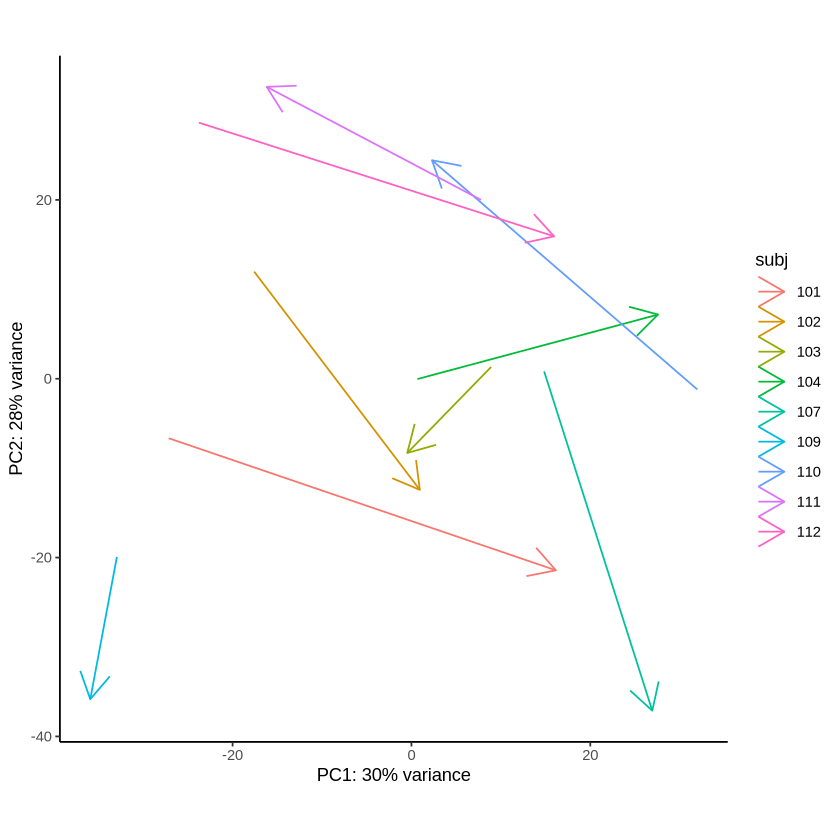

In [18]:
d <- plotPCA(vst(sfig1.dds), intgroup = c('subj', 'v'), returnData=TRUE)
percentVar <- round(100 * attr(d, "percentVar"))

d.order <- d[order(d$v), ]

ggplot(d, aes(x=PC1, y=PC2, color=subj)) +
    #geom_point(aes(shape=v)) +
    #geom_label_repel(aes(label = cf.dds$subj), show.legend=FALSE) +
    geom_path(arrow=arrow()) +
    xlab(paste0("PC1: ", percentVar[1], "% variance")) +
    ylab(paste0("PC2: ", percentVar[2], "% variance")) +
    coord_fixed() +
    #scale_color_tableau(palette = 'Tableau 10') +
    theme_classic()

ggsave(file.path(sfig1.out.dir, "sfig1a.png"), height=3, width=3, dpi=300, unit='in')
ggsave(file.path(sfig1.out.dir, "sfig1a.svg"), height=3, width=3, dpi=300, unit='in')

In [19]:
sfig1.d.manual <- plotPCA_manual(
                                vst(sfig1.dds),
                                intgroup=c("v", "subj"),
                                ntop=500,
                                pcs=10
                                )
percentVar <- round(100 * attr(sfig1.d.manual$data, "percentVar"))

using 'avgTxLength' from assays(dds), correcting for library size

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”


In [20]:
loadings <- data.frame(sfig1.d.manual$pca$rotation)
genes <- rownames(loadings)

In [21]:
for (i in 1:10) {
    print(sprintf("PC%d: %d %% variance", i, percentVar[i]))
    l <- loadings[, i]
    ord <- order (abs(l), decreasing=TRUE)
    g <- genes[ord][1:20]
    v <- paste(tx2gene[match(g, tx2gene$GENEID), ]$GENENAME, " (", round(l[ord][1:20], 4), ")")
    print(paste(v, collapse=", "))
    print("=========")
}

[1] "PC1: 30 % variance"
[1] "OMG  ( -0.1022 ), SNTN  ( -0.1003 ), CFAP43  ( -0.098 ), CIMAP3  ( -0.0955 ), LRRIQ1  ( -0.0947 ), ENSG00000258752  ( -0.0929 ), FAM216B  ( -0.0927 ), CAPSL  ( -0.0923 ), CFAP95  ( -0.0898 ), CIMIP1  ( -0.0895 ), GSTA2  ( -0.0892 ), TSPAN19  ( -0.0886 ), DNAH12  ( -0.0882 ), CLXN  ( -0.0879 ), TPPP3  ( -0.0868 ), HOATZ  ( -0.0861 ), DNAAF4-CCPG1  ( -0.0859 ), SPMIP6  ( -0.0842 ), FAM81B  ( -0.0839 ), AKAP14  ( -0.0839 )"
[1] "========="
[1] "PC2: 28 % variance"
[1] "FCGR3B  ( -0.1256 ), BCL2A1  ( -0.115 ), OSM  ( -0.1089 ), CSF3R  ( -0.1087 ), MNDA  ( -0.1085 ), G0S2  ( -0.1083 ), SLC2A3  ( -0.1082 ), IL1B  ( -0.1081 ), SRGN  ( -0.108 ), CXCR1  ( -0.1076 ), TREM1  ( -0.1056 ), AQP9  ( -0.1048 ), FPR1  ( -0.1036 ), FFAR2  ( -0.0994 ), CXCL8  ( -0.0991 ), TNFRSF10C  ( -0.0968 ), CXCR2  ( -0.0965 ), CSF2RB  ( -0.0961 ), PROK2  ( -0.092 ), PLEK  ( -0.0905 )"
[1] "========="
[1] "PC3: 10 % variance"
[1] "XIST  ( -0.2306 ), RPS4Y1  ( 0.2116 ), DDX3Y  ( 0.1882 ),

In [22]:
sfig1.dds <- DESeq(sfig1.dds)

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [23]:
v2.vs.v1 <- as.data.frame(results(sfig1.dds, contrast=c("v", "V2", "V1")))
v2.vs.v1 <- v2.vs.v1[!is.na(v2.vs.v1$padj), ]
v2.vs.v1$sign <- ""
v2.vs.v1$sign[(v2.vs.v1$log2FoldChange < 0) & (v2.vs.v1$padj < 0.05)] <- "Down"
v2.vs.v1$sign[(v2.vs.v1$log2FoldChange > 0) & (v2.vs.v1$padj < 0.05)] <- "Up"
v2.vs.v1 <- v2.vs.v1[order(v2.vs.v1$sign), ]

v2.vs.v1$GENENAME <- tx2gene[match(row.names(v2.vs.v1), tx2gene$GENEID), ]$GENENAME

In [24]:
v2.vs.v1[v2.vs.v1$padj < 0.05, ]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,sign,GENENAME
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
ENSG00000067955,873.66129,-0.4961436,0.1169342,-4.242929,2.206212e-05,0.0415243030,Down,CBFB
ENSG00000173852,718.92870,-1.7481823,0.3108405,-5.624049,1.865327e-08,0.0004564082,Down,DPY19L1
ENSG00000256349,68.60871,-7.4289384,1.4709409,-5.050467,4.407315e-07,0.0026959544,Down,ENSG00000256349
ENSG00000291214,166.04912,-0.7981875,0.1868568,-4.271653,1.940296e-05,0.0395626342,Down,ENSG00000291214
ENSG00000105255,10.45679,3.4527629,0.7824924,4.412520,1.021745e-05,0.0312500779,Up,FSD1
ENSG00000146205,52.14620,1.6964001,0.3921021,4.326424,1.515494e-05,0.0362388350,Up,ANO7
ENSG00000185658,1777.48685,1.3376503,0.2886573,4.634042,3.585937e-06,0.0170223661,Up,BRWD1
ENSG00000196361,27.70490,2.2496562,0.5138482,4.378056,1.197426e-05,0.0325540141,Up,ELAVL3
ENSG00000204291,53.26098,2.8440695,0.6598070,4.310457,1.629178e-05,0.0362388350,Up,COL15A1


Warning message:
“ggrepel: 8 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 8 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


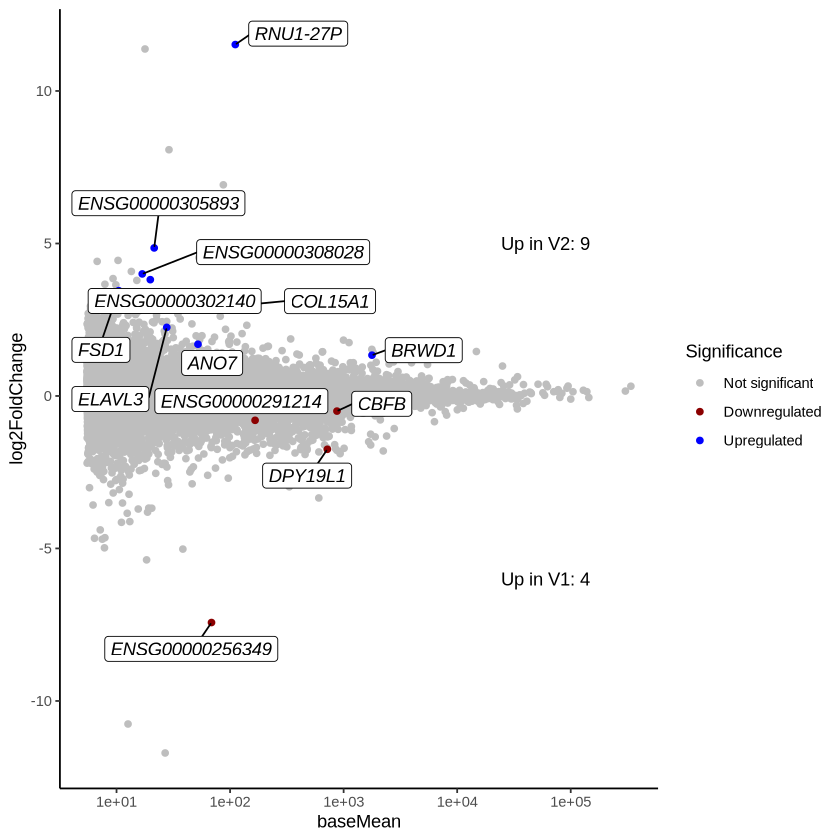

In [25]:
ggplot(v2.vs.v1, aes(x=baseMean, y=log2FoldChange)) +
    geom_point(aes(fill=sign, color=sign), stroke=0.5) +
    # ylim(-10, 10)
    geom_label_repel(
        aes(label = GENENAME, fontface = "italic"), 
        data = v2.vs.v1[v2.vs.v1$padj < 0.05, ],
        box.padding = 0.5,
        seed = 5000,
    ) +
    scale_x_log10() +
    scale_color_manual(values = c("gray", "darkred", "blue"), name = "Significance", labels = c("Not significant", "Downregulated", "Upregulated")) +
    scale_fill_manual(values = c("gray", "darkred", "blue"), name = "Significance", labels = c("Not significant", "Downregulated", "Upregulated")) + 
    annotate("text", x = 6e+04, y = 5, label = sprintf("Up in V2: %d", sum(v2.vs.v1$sign == "Up"))) +
    annotate("text", x = 6e+04, y = -6, label = sprintf("Up in V1: %d", sum(v2.vs.v1$sign == "Down"))) +
    theme_classic()

ggsave(file.path(sfig1.out.dir, "sfig1b.png"), height=3, width=4.5, dpi=300, unit='in')
ggsave(file.path(sfig1.out.dir, "sfig1b.svg"), height=3, width=4.5, dpi=300, unit='in')

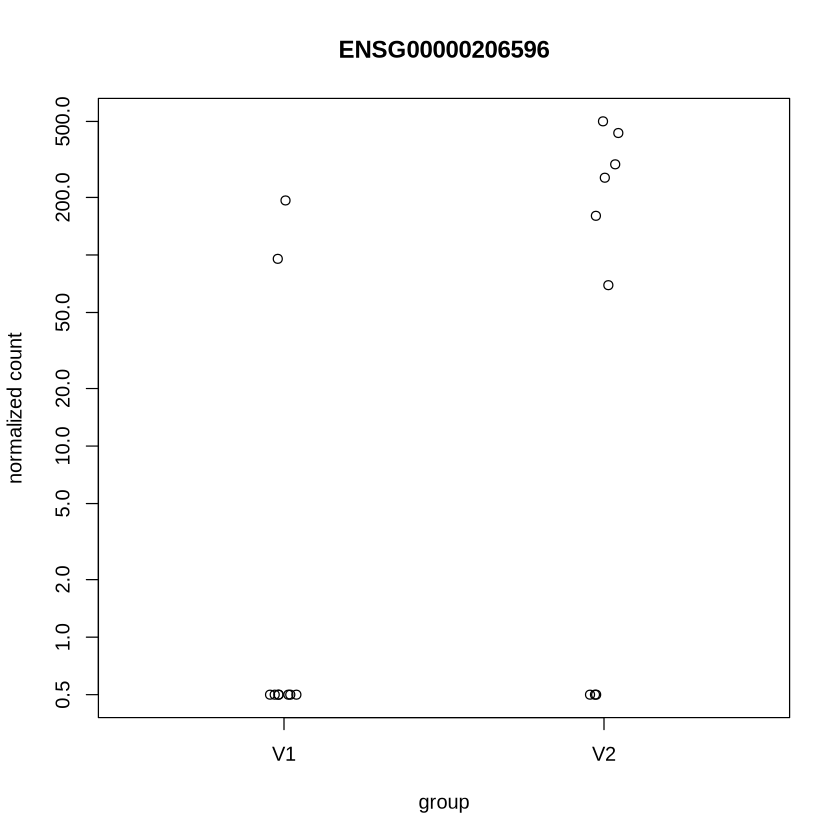

In [27]:
#RNU1-27P
plotCounts(sfig1.dds, gene="ENSG00000206596", intgroup="v")